In [1]:
import numpy as np 
import pandas as pd 
import os, re, time, math, tqdm, itertools
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as pyo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
import keras
from keras.layers import Conv2D, Conv1D, MaxPooling2D, MaxPooling1D, Flatten, BatchNormalization, Dense
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.callbacks import CSVLogger, ModelCheckpoint

Using TensorFlow backend.


In [2]:
%%time
network_data = pd.read_csv('02-14-2018.csv')

CPU times: user 5.6 s, sys: 2.92 s, total: 8.53 s
Wall time: 10.6 s


In [3]:
network_data.shape

(1048575, 80)

In [4]:
print('Number of Rows (Samples): %s' % str((network_data.shape[0])))
print('Number of Columns (Features): %s' % str((network_data.shape[1])))

Number of Rows (Samples): 1048575
Number of Columns (Features): 80


In [5]:
network_data.head(4)

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0,14/02/2018 08:31:01,112641719,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56320859.5,139.300036,56320958,56320761,Benign
1,0,0,14/02/2018 08:33:50,112641466,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56320733.0,114.551299,56320814,56320652,Benign
2,0,0,14/02/2018 08:36:39,112638623,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56319311.5,301.934596,56319525,56319098,Benign
3,22,6,14/02/2018 08:40:13,6453966,15,10,1239,2273,744,0,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,Benign


In [6]:
network_data.columns

Index(['Dst Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Tot Fwd Pkts',
       'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
      

In [7]:
print('Total columns in our data: %s' % str(len(network_data.columns)))

Total columns in our data: 80


In [8]:
network_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 80 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Dst Port           1048575 non-null  int64  
 1   Protocol           1048575 non-null  int64  
 2   Timestamp          1048575 non-null  object 
 3   Flow Duration      1048575 non-null  int64  
 4   Tot Fwd Pkts       1048575 non-null  int64  
 5   Tot Bwd Pkts       1048575 non-null  int64  
 6   TotLen Fwd Pkts    1048575 non-null  int64  
 7   TotLen Bwd Pkts    1048575 non-null  int64  
 8   Fwd Pkt Len Max    1048575 non-null  int64  
 9   Fwd Pkt Len Min    1048575 non-null  int64  
 10  Fwd Pkt Len Mean   1048575 non-null  float64
 11  Fwd Pkt Len Std    1048575 non-null  float64
 12  Bwd Pkt Len Max    1048575 non-null  int64  
 13  Bwd Pkt Len Min    1048575 non-null  int64  
 14  Bwd Pkt Len Mean   1048575 non-null  float64
 15  Bwd Pkt Len Std    1048575 non-n

In [9]:
network_data['Label'].value_counts()

Benign            667626
FTP-BruteForce    193360
SSH-Bruteforce    187589
Name: Label, dtype: int64

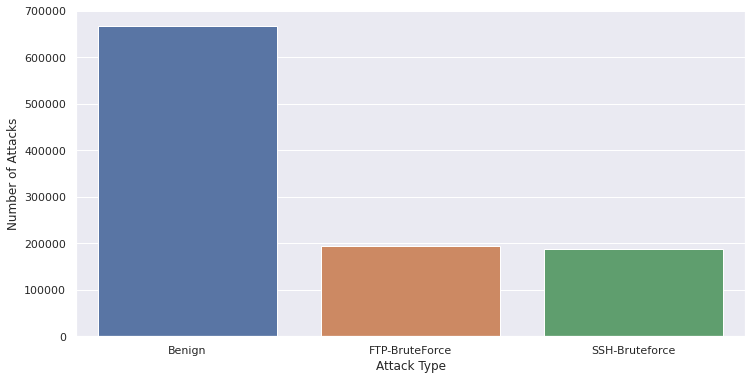

In [10]:
sns.set(rc={'figure.figsize':(12, 6)})
plt.xlabel('Attack Type')
sns.set_theme()
ax = sns.countplot(x='Label', data=network_data)
ax.set(xlabel='Attack Type', ylabel='Number of Attacks')
plt.show()

In [14]:
network_data.isna().sum().to_numpy()

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0, 2277,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0])

In [15]:
cleaned_data = network_data.dropna()
cleaned_data.isna().sum().to_numpy()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [16]:
label_encoder = LabelEncoder()
cleaned_data['Label']= label_encoder.fit_transform(cleaned_data['Label'])
cleaned_data['Label'].unique()

/root/anaconda3/envs/exp1/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



array([0, 1, 2])

In [17]:
cleaned_data['Label'].value_counts()

0    665355
1    193354
2    187589
Name: Label, dtype: int64

In [18]:
data_1 = cleaned_data[cleaned_data['Label'] == 0]
data_2 = cleaned_data[cleaned_data['Label'] == 1]
data_3 = cleaned_data[cleaned_data['Label'] == 2]

y_1 = np.zeros(data_1.shape[0])
y_benign = pd.DataFrame(y_1)

y_2 = np.ones(data_2.shape[0])
y_bf = pd.DataFrame(y_2)

y_3 = np.full(data_3.shape[0], 2)
y_ssh = pd.DataFrame(y_3)

X = pd.concat([data_1, data_2, data_3], sort=True)
y = pd.concat([y_benign, y_bf, y_ssh], sort=True)

In [19]:
y_1, y_2, y_3

(array([0., 0., 0., ..., 0., 0., 0.]),
 array([1., 1., 1., ..., 1., 1., 1.]),
 array([2, 2, 2, ..., 2, 2, 2]))

In [20]:
print(X.shape)
print(y.shape)

(1046298, 80)
(1046298, 1)


In [21]:
X.isnull().sum().to_numpy()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [22]:
from sklearn.utils import resample

data_1_resample = resample(data_1, n_samples=20000, 
                           random_state=123, replace=True)
data_2_resample = resample(data_2, n_samples=20000, 
                           random_state=123, replace=True)
data_3_resample = resample(data_3, n_samples=20000, 
                           random_state=123, replace=True)

In [23]:
train_dataset = pd.concat([data_1_resample, data_2_resample, data_3_resample])
train_dataset.head(2)

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
659775,53,17,14/02/2018 03:29:35,79333,2,2,66,254,33,33,...,8,0.0,0.0,0,0,0.0,0.0,0,0,0
409094,443,6,14/02/2018 10:03:30,621591,9,8,1542,4796,1157,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0


In [25]:
test_dataset = train_dataset.sample(frac=0.1)
target_train = train_dataset['Label']
target_test = test_dataset['Label']
target_train.unique(), target_test.unique()

(array([0, 1, 2]), array([0, 2, 1]))

In [26]:
y_train = to_categorical(target_train, num_classes=3)
y_test = to_categorical(target_test, num_classes=3)

In [27]:
train_dataset = train_dataset.drop(columns = ["Timestamp", "Protocol","PSH Flag Cnt","Init Fwd Win Byts","Flow Byts/s","Flow Pkts/s", "Label"], axis=1)
test_dataset = test_dataset.drop(columns = ["Timestamp", "Protocol","PSH Flag Cnt","Init Fwd Win Byts","Flow Byts/s","Flow Pkts/s", "Label"], axis=1)

In [28]:
X_train = train_dataset.iloc[:, :-1].values
X_test = test_dataset.iloc[:, :-1].values
X_test

array([[5.04310e+04, 7.60000e+01, 2.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [2.20000e+01, 3.17448e+05, 2.10000e+01, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [5.17650e+04, 4.00000e+01, 1.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       ...,
       [2.10000e+01, 1.00000e+00, 1.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [2.10000e+01, 2.00000e+00, 1.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [2.20000e+01, 3.74246e+05, 2.30000e+01, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00]])

In [29]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(60000, 72)
(6000, 72)
(60000, 3)
(6000, 3)


In [30]:
X_train = X_train.reshape(len(X_train), X_train.shape[1], 1)
X_test = X_test.reshape(len(X_test), X_test.shape[1], 1)
X_train.shape, X_test.shape

((60000, 72, 1), (6000, 72, 1))

In [31]:
def model():
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                    padding='same', input_shape=(72, 1)))
    model.add(BatchNormalization())
    
    
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))
    
    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                    padding='same', input_shape=(72, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))
    
    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', 
                    padding='same', input_shape=(72, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=(3), strides=2, padding='same'))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [32]:
model = model()
model.summary()








_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 72, 64)            448       
_________________________________________________________________
batch_normalization_1 (Batch (None, 72, 64)            256       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 36, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 36, 64)            24640     
_________________________________________________________________
batch_normalization_2 (Batch (None, 36, 64)            256       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 18, 64)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 18, 64)            24640     
___

In [38]:
%%time
logger = CSVLogger('logs.csv', append=True)
his = model.fit(X_train, y_train, epochs=10, batch_size=32, 
          validation_data=(X_test, y_test), callbacks=[logger])

Train on 60000 samples, validate on 6000 samples
Epoch 1/10
60000/60000 [==============================] - 24s 400us/step - loss: 0.0551 - acc: 0.9813 - val_loss: 3.5701 - val_acc: 0.4325
Epoch 2/10
60000/60000 [==============================] - 24s 399us/step - loss: 0.0569 - acc: 0.9807 - val_loss: 10.7308 - val_acc: 0.3325
Epoch 3/10
60000/60000 [==============================] - 24s 398us/step - loss: 0.0593 - acc: 0.9807 - val_loss: 1.9897 - val_acc: 0.5078
Epoch 4/10
60000/60000 [==============================] - 24s 398us/step - loss: 0.0569 - acc: 0.9830 - val_loss: 1.6815 - val_acc: 0.6600
Epoch 5/10
60000/60000 [==============================] - 33s 555us/step - loss: 0.0453 - acc: 0.9853 - val_loss: 1.7158 - val_acc: 0.5073
Epoch 6/10
60000/60000 [==============================] - 33s 548us/step - loss: 0.0524 - acc: 0.9829 - val_loss: 0.9410 - val_acc: 0.6297
Epoch 7/10
60000/60000 [==============================] - 33s 550us/step - loss: 0.0521 - acc: 0.9831 - val_loss: 1.

In [39]:
scores = model.evaluate(X_test, y_test)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1] * 100))

6000/6000 [==============================] - 1s 151us/step
acc: 61.88%


In [40]:
history = his.history
history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

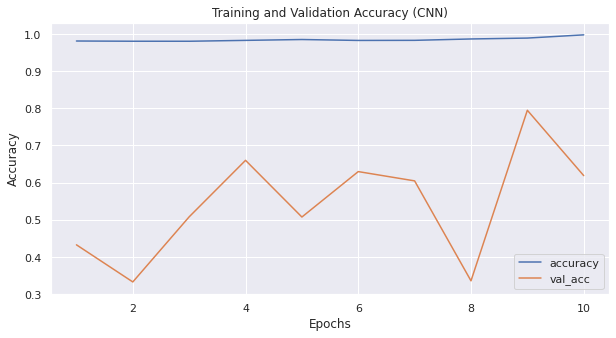

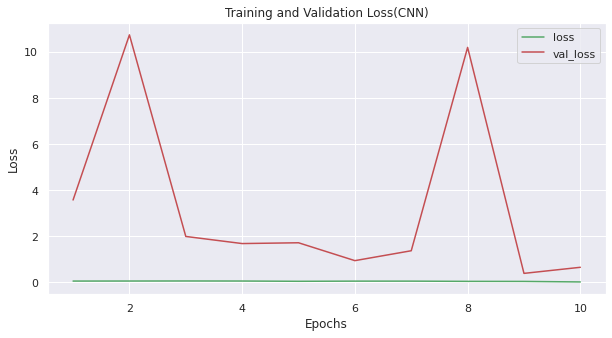

In [41]:
epochs = range(1, len(history['loss']) + 1)
acc = history['acc']
loss = history['loss']
val_acc = history['val_acc']
val_loss = history['val_loss']


plt.figure(figsize=(10, 5))
plt.title('Training and Validation Accuracy (CNN)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs, acc, label='accuracy')
plt.plot(epochs, val_acc, label='val_acc')
plt.legend()


plt.figure(figsize=(10, 5))
plt.title('Training and Validation Loss(CNN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epochs, loss, label='loss', color='g')
plt.plot(epochs, val_loss, label='val_loss', color='r')
plt.legend()